# Panorama Project - Yang Benjamin

Le but du projet est d'étudier les notions d'homographie, de RANSAC et autre. Voici le plan en 4 niveaux :

1. Les transformations géométriques
2. Feature Matching
3. RANSAC
4. Image Stitching and Blending

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def im_show(img, title="Result"):
    plt.figure(figsize=(10, 8))
    
    # Cas 1 : Image en niveaux de gris (Matrice 2D)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray', vmin=0, vmax=255)
        
    # Cas 2 : Image couleur (Tenseur 3D)
    else:
        # On passe de BGR (OpenCV) à RGB (Matplotlib)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        
    plt.title(title)
    plt.axis('off')
    plt.show()

## Les transformations géométriques

Étudions dans un premier temps les notions d'homographie et de Warping.

### L'homographie

Imaginons une image sur un tapis déformable.
* Si on zoome, c'est une **homotéthie**
* Si on tourne, c'est une **rotation**
* Si on tire sur un coin et qu'on déforme, c'est une **homographie**

L'homographie ne conserve donc pas nécessairement les angles ni les distances

Afin de pouvoir réaliser cette transformation, on doit passer en **coordonnées homogènes**. 

On ajoute donc une dimension au point (x,y) :
$\begin{pmatrix} x \\ y \\ 1 \end{pmatrix}$.

L'homographie est une matrice $3 \times 3$ notée $H$ :$$\begin{pmatrix} x' \\ y' \\ w' \end{pmatrix} = \begin{pmatrix} h_{11} & h_{12} & h_{13} \\ h_{21} & h_{22} & h_{23} \\ h_{31} & h_{32} & h_{33} \end{pmatrix} \begin{pmatrix} x \\ y \\ 1 \end{pmatrix}$$

Ainsi, à la fin, on obtient un vecteur w' qui n'est plus égal à 1, de fait, on aura :
$$x_{final} = \frac{x'}{w'} \quad , \quad y_{final} = \frac{y'}{w'}$$

Naturellement, on voudrait coder de l'image source à l'image destination. Mais lors d'une transformation, le caractère discret de l'information contenue dans l'image imposera à cette méthode des trous et des vides. C'est pourquoi il convient d'appliquer l'inverse Mapping.

Lors de cette transformation inverse, la valeur que nous donnera notre matrice H inverse ne sera pas entière. C'est pourquoi nous calculerons une interpolation pour estimer le couleur du point. Cette couleur est donnée par :

$V = (1-dx)(1-dy) \cdot I(x,y) + (dx)(1-dy) \cdot I(x+1,y) + (1-dx)(dy) \cdot I(x,y+1) + (dx)(dy) \cdot I(x+1,y+1)$

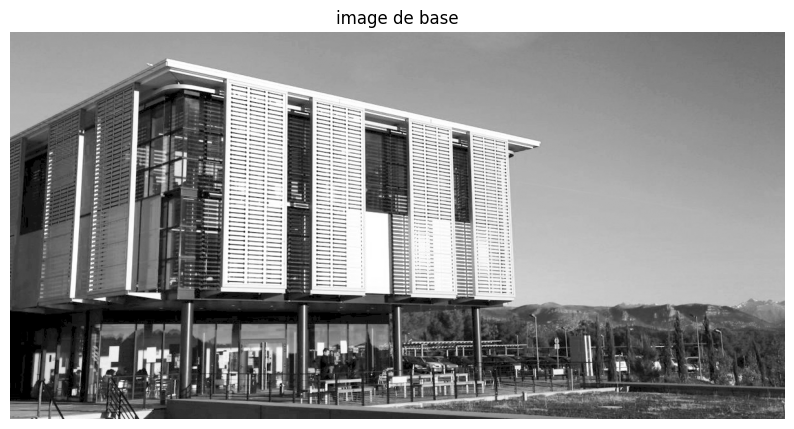

In [45]:
img = cv2.imread("../data/pns_original.png", cv2.IMREAD_GRAYSCALE)
im_show(img, 'image de base')

In [15]:
def warping_pixel(img, x_f, y_f):
    img = img.astype(np.float32)
    x, y = np.floor(x_f).astype(int), np.floor(y_f).astype(int)
    #print(x, y)
    dx, dy = x_f-x, y_f-y

    return (1-dx)*(1-dy)*img[x,y] + dx*(1-dy)*img[x+1, y] + (1-dx)*dy*img[x, y+1] + dx*dy*img[x+1, y+1]

In [16]:
warping_pixel(img, 60.3, 72.3)

np.float64(168.0)

In [61]:
# On définit H (Exemple : une petite rotation + translation)
theta = np.radians(10)
H = np.array([
    [np.cos(theta), -np.sin(theta), 10],
    [np.sin(theta),  np.cos(theta), 20],
    [0,              0,             1]
])

In [62]:
h, w = img.shape #hauteur et largeur de notre image d'arrivée
y_f, x_f = np.indices((h, w))
x_f.flatten() #aplatit toute notre matrice sur le vecteur
n = h*w #taille du vecteur P en coordonnées homogènes (pour vectoriser)
P_dest = np.ones((3, n))
#print(P.shape)
P_dest[:-1, :] = np.array([x_f.flatten(), y_f.flatten()])
P_dest

array([[0.000e+00, 1.000e+00, 2.000e+00, ..., 1.197e+03, 1.198e+03,
        1.199e+03],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.990e+02, 5.990e+02,
        5.990e+02],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], shape=(3, 720000))

On crée la matrice de coordonnées $\mathbf{P}_{dest}$ de taille $(3, N)$ où $N = H \times W$ :$$\mathbf{P}_{dest} = \begin{pmatrix} x_1 & x_2 & \cdots & x_n \\ y_1 & y_2 & \cdots & y_n \\ 1 & 1 & \cdots & 1 \end{pmatrix}$$

Puis on cherche d'où viennent ces points dans l'image source en utilisant $H^{-1}$ :$$\mathbf{P}_{src\_h} = H^{-1} \cdot \mathbf{P}_{dest}$$

Cela nous donne des coordonnées homogènes sources $\begin{pmatrix} x'_h \\ y'_h \\ w'_h \end{pmatrix}$. Pour obtenir les positions réelles $(x_f, y_f)$ sur lesquelles notre interpolation va travailler, on divise par $w'_h$ :$$x_f = \frac{x'_h}{w'_h}, \quad y_f = \frac{y'_h}{w'_h}$$

In [63]:
def warping(img, x_arr, y_arr):
    h, w = img.shape
    x0, y0 = np.clip(np.floor(x_arr).astype(int), 0, w-1), np.clip(np.floor(y_arr).astype(int), 0, h-1)
    x1, y1 = np.clip(x0+1, 0, w-1), np.clip(y0+1, 0, h-1)
    dx, dy = x_arr-x0, y_arr-y0
    pixels = (1-dx)*(1-dy)*img[y0,x0] + dx*(1-dy)*img[y0, x1] + (1-dx)*dy*img[y1, x0] + dx*dy*img[y1, x1]
    #pixels = (1-dx)*(1-dy)*img[x0,y0] + dx*(1-dy)*img[x0, y1] + (1-dx)*dy*img[x1, y0] + dx*dy*img[x1, y1]
    return pixels

In [64]:
P_src = np.linalg.inv(H) @ P_dest
x_src = P_src[0] / P_src[2]
y_src = P_src[1] / P_src[2]

On obtient ici les coordonnées de notre image de base, donc on va pouvoir extraire toutes les valeurs avec notre interpolation du dessus :

In [65]:
pixels_final = warping(img, x_src, y_src)
img_final = pixels_final.reshape((h, w))

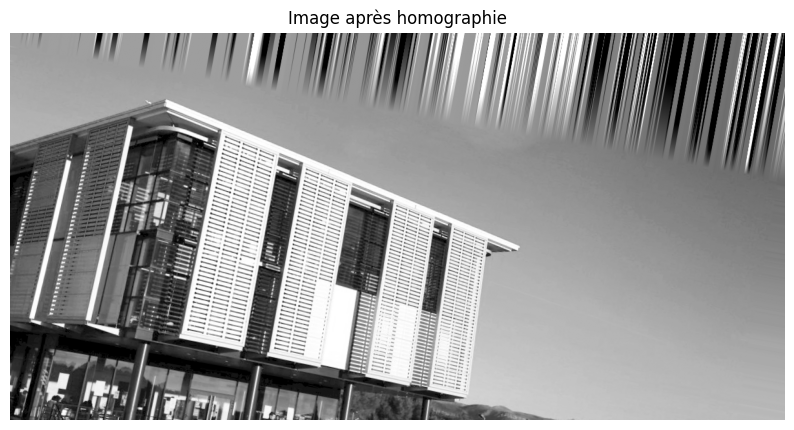

In [66]:
im_show(img_final, "Image après homographie")

In [90]:
def homographie(img, H, h=None, w=None):
    if h == None or w == None : h, w = img.shape #hauteur et largeur de notre image d'arrivée
    y_f, x_f = np.indices((h, w))
    n = h*w #taille du vecteur P en coordonnées homogènes (pour vectoriser)
    P_dest = np.ones((3, n))
    P_dest[:-1, :] = np.array([x_f.flatten(), y_f.flatten()])

    P_src = np.linalg.inv(H) @ P_dest
    x_src = P_src[0] / P_src[2]
    y_src = P_src[1] / P_src[2]

    pixels_final = warping(img, x_src, y_src)
    img_final = pixels_final.reshape((h, w))

    return img_final

def test_homographie(img, H, h=None, w=None):
    img_f = homographie(img, H, h, w)
    im_show(img, "Image Originale")
    im_show(img_f, "Image modifiée")

C'est le moment d'expérimenter les différentes matrices H.

Pour théoriser un peu, voici :
Les deux premières lignes contrôlent ce qui se passe "à plat" sur l'image.$$H = \begin{pmatrix} \color{red}{a} & \color{red}{b} & \color{blue}{t_x} \\ \color{red}{c} & \color{red}{d} & \color{blue}{t_y} \\ \color{green}{g} & \color{green}{h} & 1 \end{pmatrix}$$

A. La Translation (Le bloc bleu) : $$x' = 1 \cdot x + 0 \cdot y + t_x$$ $$y' = 0 \cdot x + 1 \cdot y + t_y$$

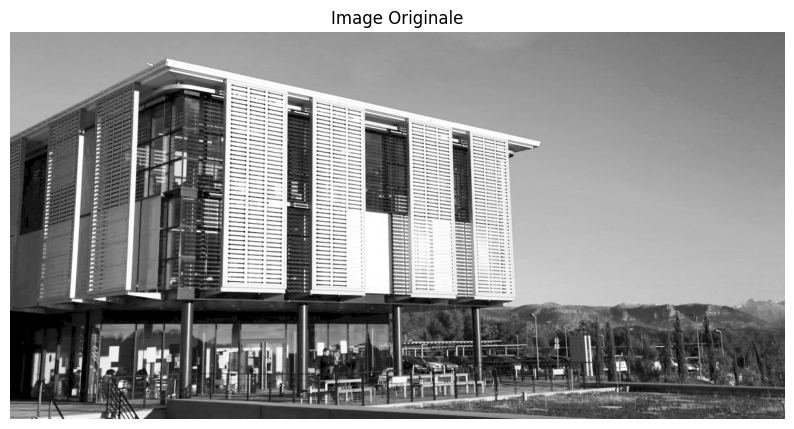

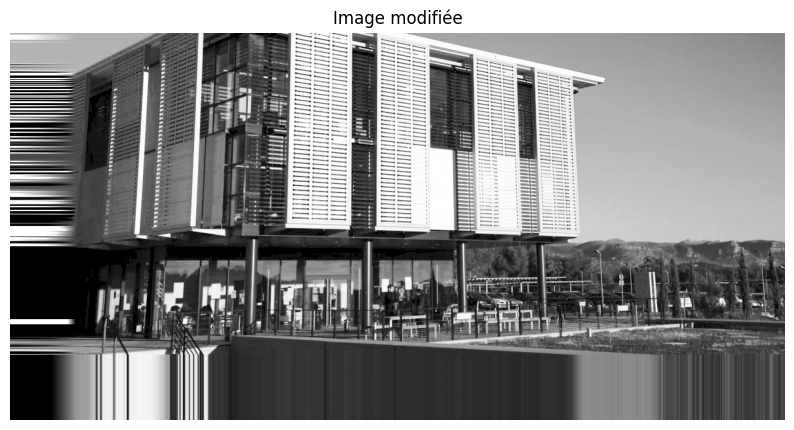

In [91]:
tx = 100
ty = -100
H = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0.0, 1]
])
test_homographie(img, H)

B. Le Scale

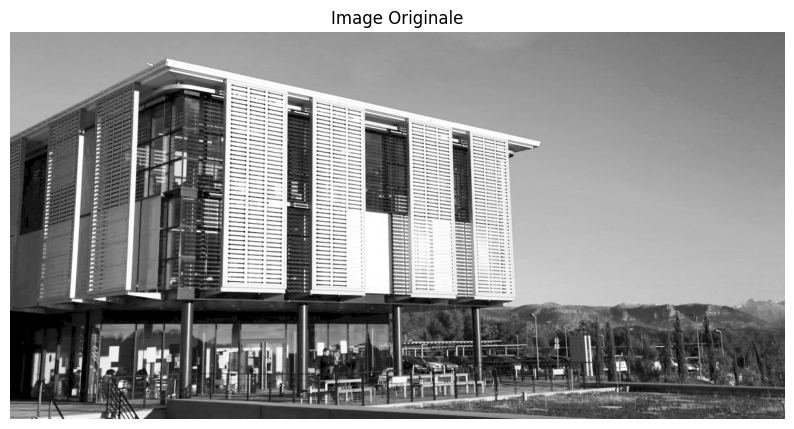

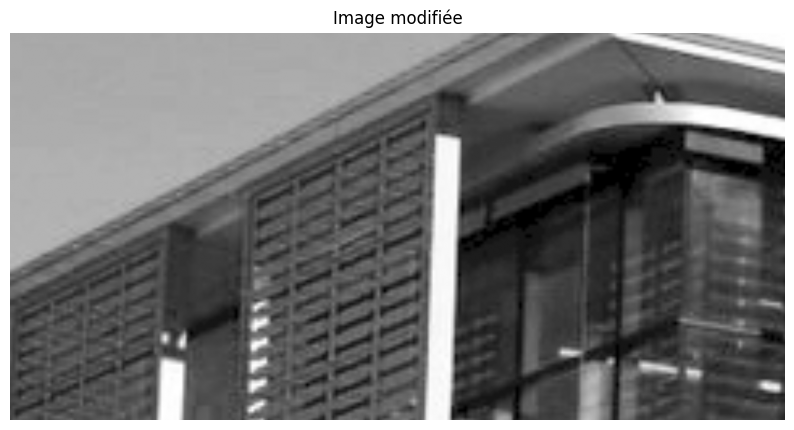

In [184]:
H = np.array([
    [5, 0, -300],
    [0, 5, -300],
    [0, 0, 1]
])
test_homographie(img, H)

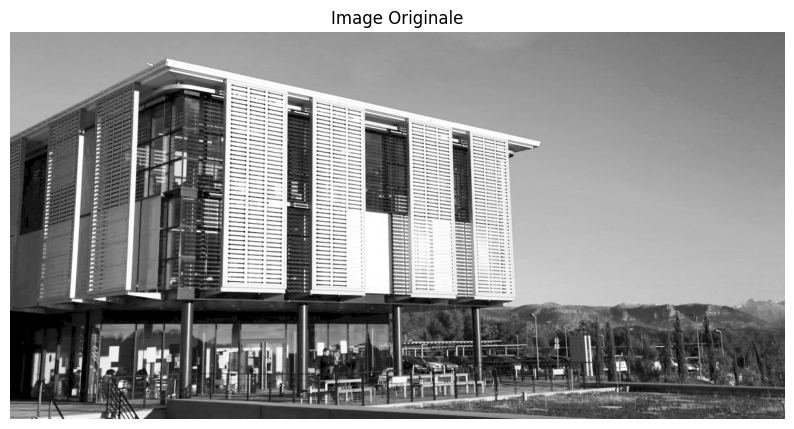

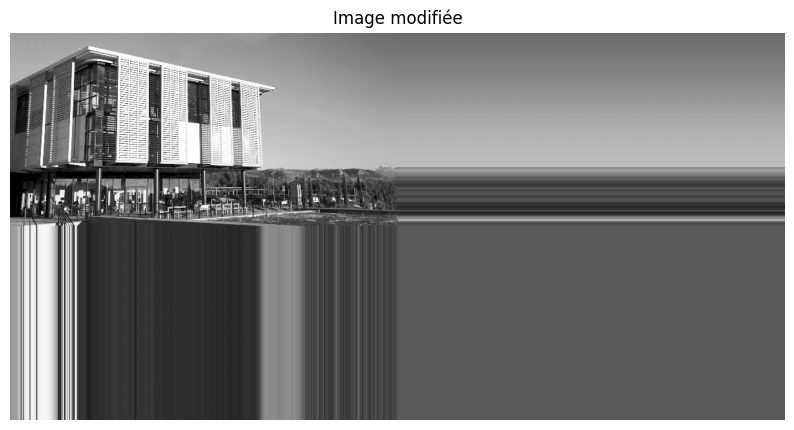

In [93]:
H = np.array([
    [0.5, 0, 0],
    [0, 0.5, 0],
    [0, 0, 1]
])
test_homographie(img, H)

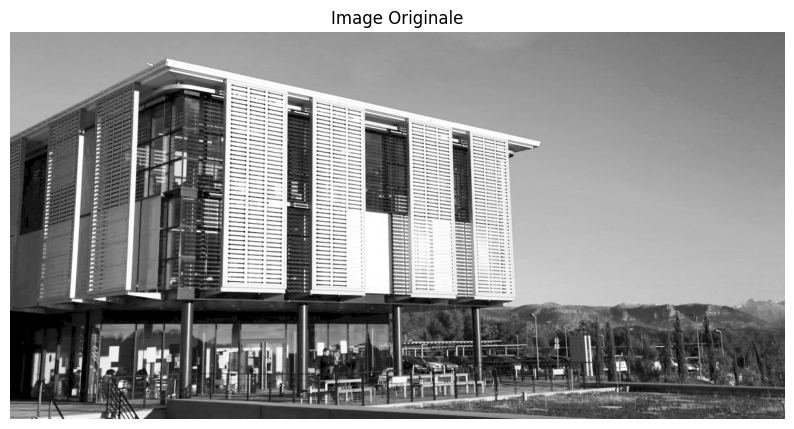

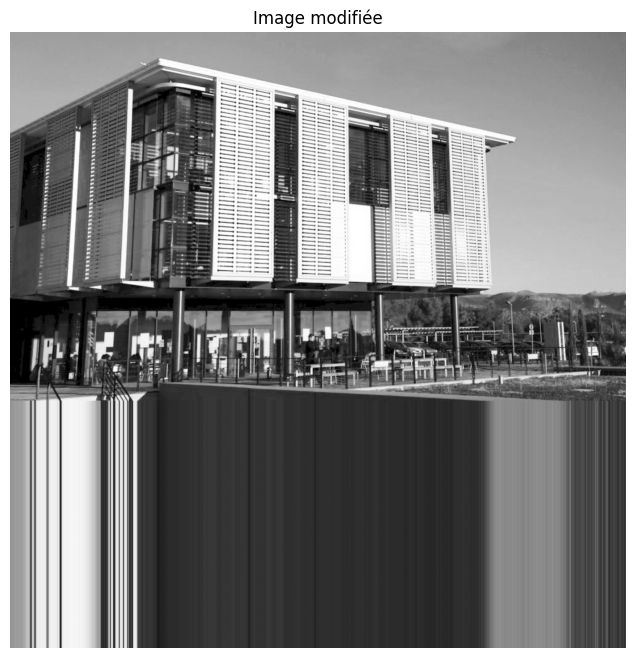

In [94]:
H = np.array([
    [2, 0, 0],
    [0, 2, 0],
    [0, 0, 1]
])
test_homographie(img, H, 2000, 2000)

On remarque ici que l'origine du repère est situé au point en haut à gauche. On peut donc viser une transformation de matrice pour modifier l'origine au centre de l'image.

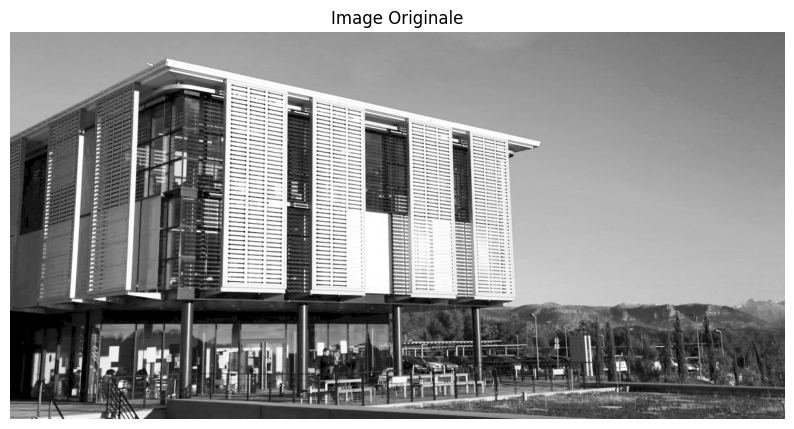

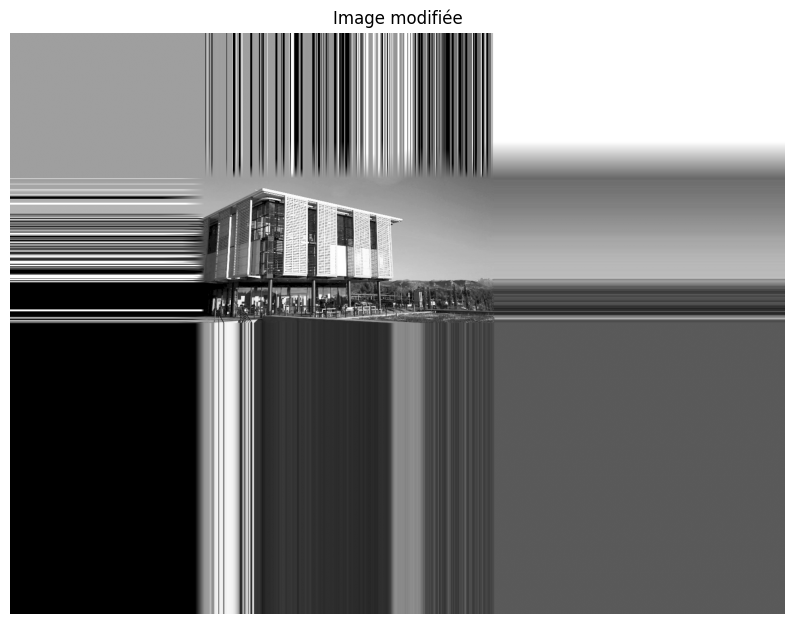

In [95]:
H = np.array([
    [0.5, 0, 400],
    [0, 0.5, 300],
    [0, 0, 1]
])
test_homographie(img, H, 1200, 1600)

## Feature Matching & RANSAC

Après avoir étudié l'homographie, et vu comment la matrice H manipule une image dans l'espace (translation, rotation, zoom, perspective), on va faire en sorte que l'ordinateur détermine automatiquement notre H (donc notre matrice d'homographie) pour pouvoir bien recoller les images.

Je vais commencer par importer mon ancienne fonction de détection des coins harris que l'on avait créé dans le projet sobel-harris

In [100]:
def convolution(image, C):
    C_n, C_m = C.shape[0]-1, C.shape[1]-1
    img_b = np.zeros((image.shape[0]+C_n, image.shape[1]+C_m)).astype(np.float32)
    decalage = C_n//2
    img_b[decalage:-decalage, decalage:-decalage] = image

    res = np.zeros_like(image).astype(np.float32)
    n, m = res.shape[0], res.shape[1]
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            res += C[i, j]*img_b[i:n+i, j:m+j]
    return res

def harris_detection(img, k=0.04, seuil=0.01):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = Kx.T
    
    Gx = convolution(img, Kx)
    Gy = convolution(img, Ky)

    Ixx = Gx*Gx
    Iyy = Gy*Gy
    Ixy = Gx*Gy

    blur = np.ones((3,3))/9.0
    Sxx = convolution(Ixx, blur)
    Syy = convolution(Iyy, blur)
    Sxy = convolution(Ixy, blur)

    det_m = Sxx*Syy - Sxy**2
    trace_m = Sxx + Syy
    R = det_m - k*(trace_m**2)

    seuil = seuil*R.max()
    corners = np.where(R > seuil)
    
    return corners

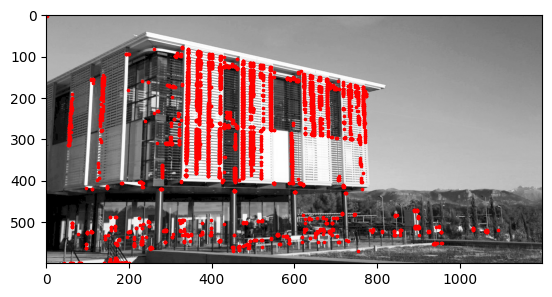

In [106]:
plt.imshow(img, cmap='gray')
corners = harris_detection(img, k=0.04, seuil=0.1)
plt.scatter(corners[1], corners[0], s=10, c='red', marker='.')
plt.show()

Je vais utiliser deux images que l'on pourra "panoramifier", et ensuite, nous allons extraire un patch tout autour de nos coins pour les comparer. Nous pourrons alors identifier à l'aide de la **SSD** quel est le coin de l'image B qui colle le plus à l'image A et donc localiser et modifier la matrice H en conséquence.

RANSAC interviendra quand il y aura des points qui se ressemblent énormément : pour cela on prendra aléatoirement des paires et comparera en fonction de la matrice H créée si les autres points correspondent bien.

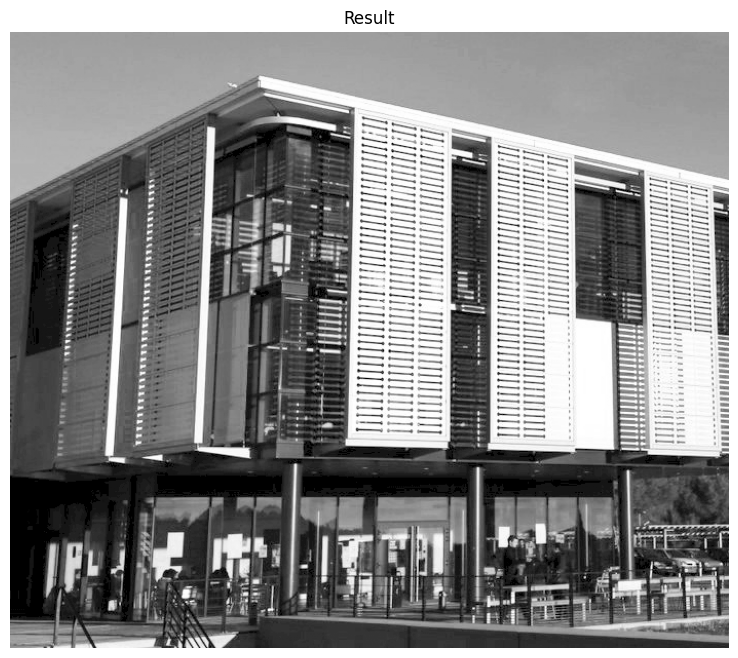

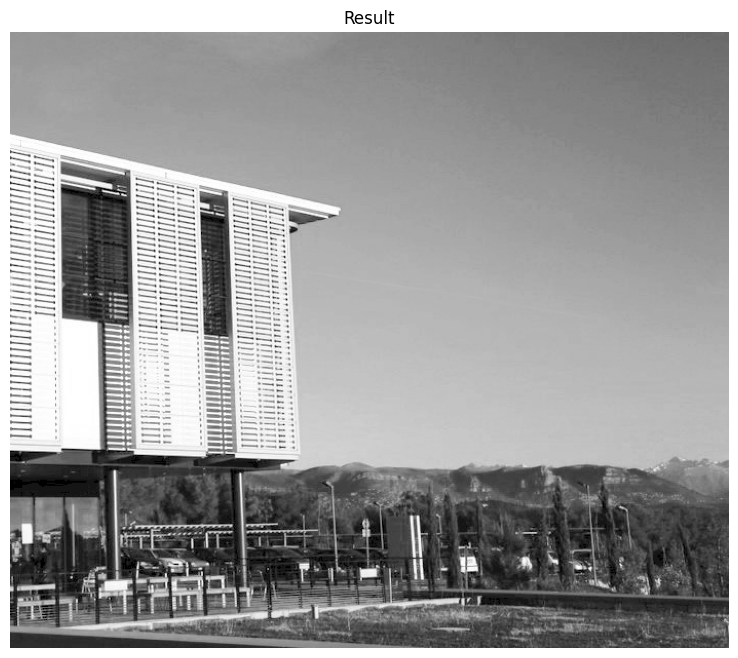

In [105]:
img1 = img[:, : 700]
img2 = img[:, 500 :]
im_show(img1)
im_show(img2)

In [107]:
corners

(array([  1,  77,  77, ..., 599, 599, 599], shape=(4080,)),
 array([  1, 328, 329, ..., 192, 193, 200], shape=(4080,)))

On va ensuite extraire les descripteurs de tous les points :

In [ ]:
def descripteurs(img, corners, patch_size=3):
    rayon_patch = patch_size//2
    y = corners[0]
    x = corners[1]
    liste_descripteurs = []
    indices_valides = []
    for i in range(len(y)):
        if y[i]-rayon_patch < 0 or y[i]+rayon_patch+1 > img.shape[0] or x[i]-rayon_patch < 0 or x[i]+rayon_patch+1 > img.shape[1]:
            continue
        yi = y[i]
        xi = x[i]
        patch = img[yi-rayon_patch: yi+rayon_patch+1, xi-rayon_patch:xi+rayon_patch+1]
        # On normalise en enlevant la moyenne et en divisant par l'écart-type
        patch_norm = (patch-np.mean(patch)) / (np.std(patch) + 1e-8) #On ajoute une mini valeur pour éviter la division par zéro et avoir une erreur
        liste_descripteurs.append(patch_norm.flatten())
        indices_valides.append(i)

    return np.array(liste_descripteurs), indices_valides   

In [173]:
def descripteurs_vec(img, corners, patch_size=3):
    r_patch = patch_size//2
    h, w = img.shape
    y, x = corners
    mask = (y >= r_patch) & (y < h - r_patch) & (x >= r_patch) & (x < w - r_patch)
    y_v = y[mask]
    x_v = x[mask]
    n = len(y_v) #nb points
    liste_descripteurs = np.ones((n, patch_size**2))
    compteur = 0
    for i in range(patch_size):
        for j in range(patch_size):
            pixel_of_all_patches = img[y_v-r_patch+i, x_v-r_patch+j] #extrait pour tous les points un des pixels du patchs
            liste_descripteurs[:, compteur] = pixel_of_all_patches
            compteur += 1
    mean_desc = np.mean(liste_descripteurs, axis=1, keepdims=True) #on calcule les moyennes par rapport à l'axe des colonnes (axis=1)
    std_desc = np.std(liste_descripteurs, axis=1, keepdims=True)
    liste_descripteurs = (liste_descripteurs-mean_desc)/(std_desc+1e-8)
            
    return liste_descripteurs, np.column_stack((y_v, x_v))

In [174]:
liste_descripteurs, indices_valides = descripteurs_vec(img, corners, patch_size=3)

Soit $\mathbf{a}$ un vecteur de l'image A et $\mathbf{b}$ un vecteur de l'image B. On veut :$$dist(\mathbf{a}, \mathbf{b}) = \sqrt{\sum (a_i - b_i)^2}$$

Développons le carré :$$\|\mathbf{a} - \mathbf{b}\|^2 = \|\mathbf{a}\|^2 + \|\mathbf{b}\|^2 - 2(\mathbf{a} \cdot \mathbf{b})$$

Ceci fonctionne donc au niveau matriciel ! De fait, si on considère ma matrice A de tous mes descripteurs avec N lignes, ma matrice B de M lignes, on va comparer pour chaque ligne de A à toutes les lignes de B, puis renvoyer la valeur. Autrement dit, on arrive avec une matrice NxM.

In [138]:
def cdist(A, B):
    a_squared = np.sum(A**2, axis=1) #la somme sur chaque patch
    b_squared = np.sum(B**2, axis=1)
    dist = a_squared + b_squared #- 2*(A@B.transpose())
    return np.sqrt(np.maximum(dist, 0)) #pour éviter les imprécisions de calcul

In [122]:
liste_descripteurs

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.5216975 , -0.12592698, -2.44658139, ..., -0.88148888,
         0.19788526,  0.5216975 ],
       [ 0.66824744,  0.04658456, -1.48588674, ...,  0.7549911 ,
         0.84173476, -1.12445483],
       ...,
       [ 0.88823811,  1.4699015 , -0.64794982, ..., -1.8112766 ,
         0.09777248, -0.57337759],
       [ 1.64109835, -0.09509676, -1.13436848, ...,  0.51623955,
        -0.03396313, -1.13436848],
       [ 0.40904379,  0.56102795,  0.57791507, ..., -2.57997801,
         0.17262398,  0.4765923 ]], shape=(4053, 9))

Appliquons pour le moment sur nos deux images :

In [127]:
corners_img1 = harris_detection(img1, seuil=0.1)
corners_img2 = harris_detection(img2, seuil=0.1)

In [175]:
patch_size = 3
liste_descripteurs_img1, valid_idx1 = descripteurs_vec(img, corners_img1, patch_size)
liste_descripteurs_img2, valid_idx2 = descripteurs_vec(img, corners_img2, patch_size)

In [176]:
liste_descripteurs_img1

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.64888568,  0.81110709,  2.27109986, ..., -0.64888568,
        -0.64888568, -0.64888568],
       [ 0.5216975 , -0.12592698, -2.44658139, ..., -0.88148888,
         0.19788526,  0.5216975 ],
       ...,
       [ 0.88823811,  1.4699015 , -0.64794982, ..., -1.8112766 ,
         0.09777248, -0.57337759],
       [ 1.64109835, -0.09509676, -1.13436848, ...,  0.51623955,
        -0.03396313, -1.13436848],
       [ 0.40904379,  0.56102795,  0.57791507, ..., -2.57997801,
         0.17262398,  0.4765923 ]], shape=(3772, 9))

In [139]:
distances = cdist(liste_descripteurs_img1, liste_descripteurs_img2)
distances

ValueError: operands could not be broadcast together with shapes (3772,) (2633,) 

In [140]:
def cdist(A, B):
    a_squared = np.sum(A**2, axis=1).reshape(-1, 1) #la somme sur chaque patch
    # on reshape pour transformer en vecteur colonne
    b_squared = np.sum(B**2, axis=1).reshape(1, -1) # on transforme ici en vecteur ligne
    dist = a_squared + b_squared - 2*(A@B.transpose()) #l'addition nous donnera donc la matrice NxM
    return np.sqrt(np.maximum(dist, 0)) #pour éviter les imprécisions de calcul

In [142]:
distances = cdist(liste_descripteurs_img1, liste_descripteurs_img2)
distances

array([[0.        , 2.99999994, 2.99999994, ..., 3.        , 3.        ,
        3.        ],
       [2.99999996, 5.12435025, 5.32200216, ..., 5.13853375, 4.8401477 ,
        5.3515859 ],
       [3.        , 4.32283577, 3.04945014, ..., 4.39235746, 2.89148923,
        3.232197  ],
       ...,
       [3.        , 5.26330854, 5.02550697, ..., 4.71550804, 4.7611115 ,
        5.13338898],
       [3.        , 4.55703762, 4.44369339, ..., 3.6460379 , 4.81370184,
        4.51935772],
       [3.        , 5.11776589, 4.95656648, ..., 5.24127157, 4.24570919,
        5.02164949]], shape=(3772, 2633))

In [146]:
np.sort(distances, axis=1)

array([[0.        , 0.        , 0.        , ..., 3.        , 3.        ,
        3.        ],
       [0.84196368, 1.12835374, 1.1317378 , ..., 5.9025268 , 5.94596049,
        5.99805705],
       [1.36328255, 1.55886217, 1.55886219, ..., 5.79395793, 5.79395794,
        5.88859966],
       ...,
       [0.78108067, 1.48400854, 1.49128166, ..., 5.83974899, 5.859103  ,
        5.89036816],
       [0.51000531, 0.56235096, 0.63902204, ..., 5.96462042, 5.97629741,
        5.97669974],
       [0.94066158, 1.0767642 , 1.08985475, ..., 5.92833331, 5.95474852,
        5.95984158]], shape=(3772, 2633))

In [149]:
np.argpartition(distances, kth=2)

array([[   0,    8,   11, ..., 2630, 2631, 2632],
       [ 254, 2464, 1112, ..., 2630, 2631, 2632],
       [1793,    7, 2237, ..., 2630, 2631, 2632],
       ...,
       [1977, 1395, 2443, ..., 2630, 2631, 2632],
       [2067, 2400, 1271, ..., 2630, 2631, 2632],
       [1911, 1953, 2061, ..., 2630, 2631, 2632]], shape=(3772, 2633))

Maintenant, on a la matrice qui nous donne la distance des patchs pour chaque point de A par rapport à chaque point de B. (on a pris un patch de taille 3 pour le moment)
On va donc désormais trouver les patchs qui se ressemblent le plus.

Pour cela, on va trier pour chaque point de A selon la ressemblance avec les patchs de B (et prendre les indices pas les valeurs), puis on va prendre les 2 premiers de chaque

In [165]:
def match_points(desc1, desc2, seuil_lowe, seuil_abs):
    distances = cdist(desc1, desc2)
    best_patches_idx = np.argpartition(distances, kth=2, axis=1)[:, :2] #nous donne les indices des sort
    lignes = np.arange(len(distances))
    d1 = distances[lignes, best_patches_idx[:, 0]]
    d2 = distances[lignes, best_patches_idx[:, 1]]

    lowe_ratios = d1/(d2+1e-8)
    mask = (lowe_ratios<=seuil_lowe) & (d1<=seuil_abs)
    indices_a = lignes[mask]
    indices_b = best_patches_idx[mask, 0]

    return np.column_stack((indices_a, indices_b))

In [167]:
matching_points = match_points(liste_descripteurs_img1, liste_descripteurs_img2, 0.7, 10)
matching_points.shape

(442, 2)

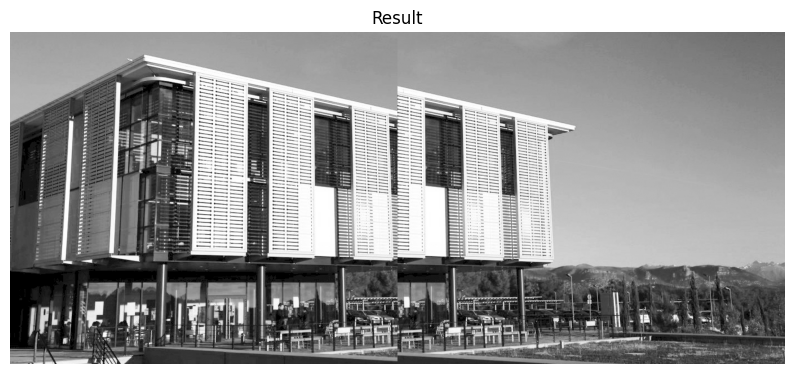

In [170]:
im_show(np.hstack((img1, img2)))

In [172]:
valid_idx1

[array([  1,   1,  77, ..., 598, 598, 598], shape=(3772,)),
 array([  1, 698, 328, ..., 192, 193, 200], shape=(3772,))]

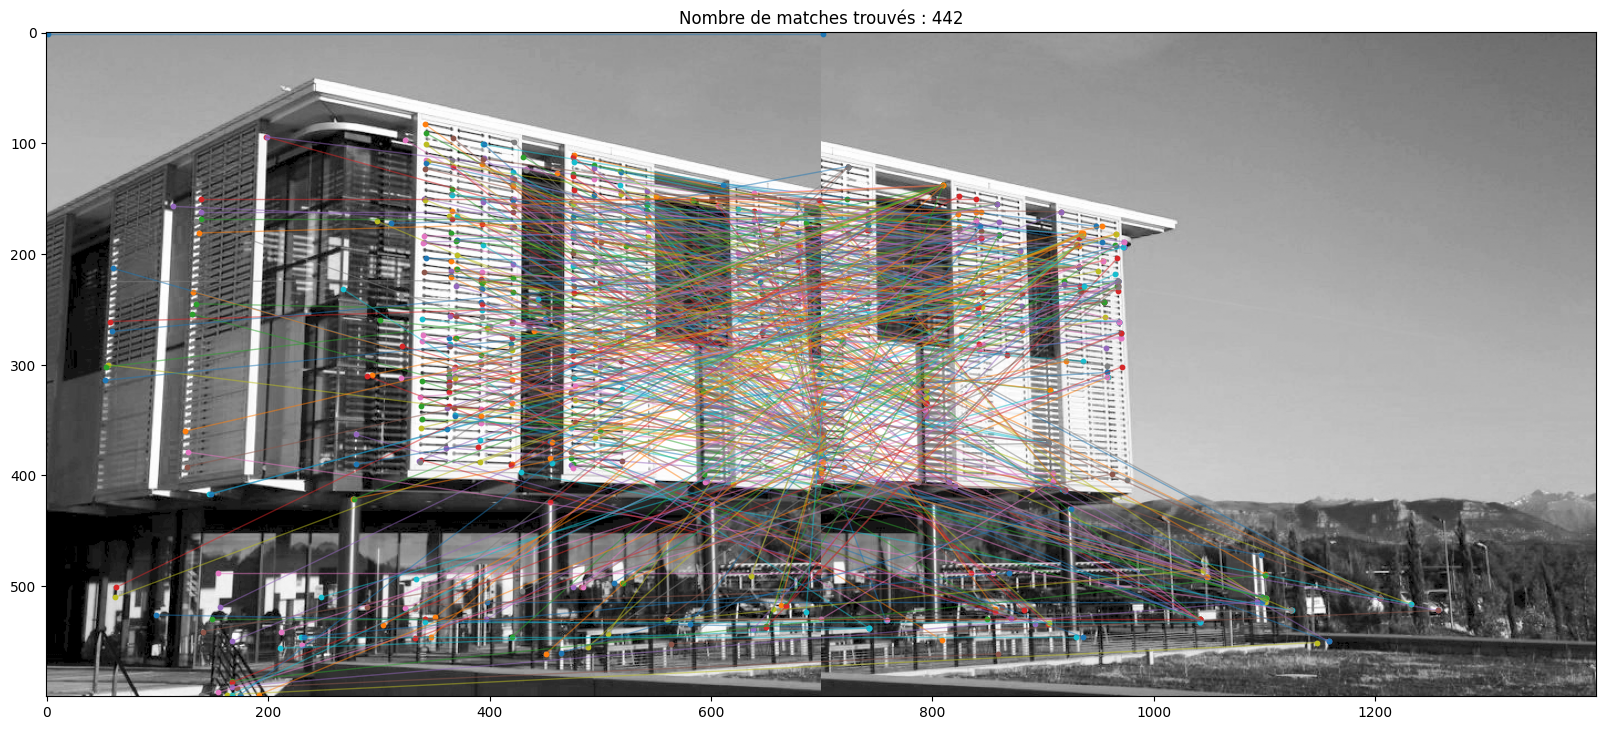

In [ ]:
import matplotlib.pyplot as plt

image_combinee = np.hstack((img1, img2))
offset = img1.shape[1] # La largeur de la première image

plt.figure(figsize=(20, 10))
plt.imshow(image_combinee, cmap='gray')

# On trace les lignes pour chaque match
for idx_A, idx_B in matching_points:
    # On récupère les coordonnées (y, x) depuis les listes de corners filtrées
    yA, xA = valid_idx1[idx_A]
    yB, xB = valid_idx2[idx_B]
    
    # On trace la ligne (xA, yA) -> (xB + offset, yB)
    plt.plot([xA, xB + offset], [yA, yB], alpha=0.5, linewidth=1)
    plt.scatter([xA, xB + offset], [yA, yB], s=10)

plt.title(f"Nombre de matches trouvés : {len(matching_points)}")
plt.show()

On observe beaucoup de faux positifs. Ces derniers sont appelés spaghettis !
Notre image contient également énormément de coins, ce qui ne facilite pas la tâche du tout. On étudiera un cas moins complexe après mais cette image de polytech est intéressante

#### Comment donc déterminer H avec ces couples de points ?

Chaque couple $(x, y) \to (x', y')$ nous donne deux équations : $$x' = \frac{h_{11}x + h_{12}y + h_{13}}{h_{31}x + h_{32}y + 1}$$ $$y' = \frac{h_{21}x + h_{22}y + h_{23}}{h_{31}x + h_{32}y + 1}$$En multipliant par le dénominateur, on obtient un système linéaire de la forme $A \cdot h = 0$.

$$x'_i(h_{31}x_i + h_{32}y_i + 1) = h_{11}x_i + h_{12}y_i + h_{13}$$
$$-h_{11}x_i - h_{12}y_i - h_{13} + (0 \cdot h_{21} + 0 \cdot h_{22} + 0 \cdot h_{23}) + h_{31}x_i x'_i + h_{32}y_i x'_i + x'_i = 0$$

On fait la même chose pour yi. on a donc deux lignes d'équation :

1. $$-x \cdot h_{11} - y \cdot h_{12} - 1 \cdot h_{13} + 0 + 0 + 0 + (x x') \cdot h_{31} + (y x') \cdot h_{32} + x' = 0$$
2. $$0 + 0 + 0 - x \cdot h_{21} - y \cdot h_{22} - 1 \cdot h_{23} + (x y') \cdot h_{31} + (y y') \cdot h_{32} + y' = 0$$

Donc avec 4 points, on obtient une matrice A 8x9, avec $A \cdot h = 0$.

##### Résoudre $A \cdot h = 0$.

On veut donc résoudre ces équations pour 4 points (4 correspondances en fait donc 8 points)

Ceci revient à chercher le vecteur h :
$$\mathbf{h} = [h_{11}, h_{12}, h_{13}, h_{21}, h_{22}, h_{23}, h_{31}, h_{32}, h_{33}]^T$$

Donc pour chaque paire de points, on a les deux vecteurs suivants :

$$\begin{pmatrix}
-x_i & -y_i & -1 & 0 & 0 & 0 & x_i x'_i & y_i x'_i & x'_i
\end{pmatrix}$$
$$\begin{pmatrix}
0 & 0 & 0 & -x_i & -y_i & -1 & x_i y'_i & y_i y'_i & y'_i
\end{pmatrix}$$

On a donc 9 inconnues et 8 équations, mais comme on l'a dit précédemment, notre h33 est généralement fixé à 1. On utilise la **SVD** pour résoudre ce problème.

Comme je n'ai pas encore codé ma propre version de la SVD encore dans l'ensemble de tous les projets que je fais, je vais utiliser une fonction toute faite. Cependant, je compte bien reprendre un projet de svd, avec la décomposition QR je crois (je ne me rappelle plus très bien mais voilà) et donc implémenter ces méthodes itératives lourdes.

In [193]:
def calculer_homographie(pts_src, pts_dst):
    # on a 4 points sources et 4 points destination, on veut calculer l'homographie
    A = [] #On construit la matrice A
    for i in range(len(pts_src)): #boucle de 4 itérations
        x, y = pts_src[i]
        xp, yp = pts_dst[i]
        A.append([-x, -y, -1, 0, 0, 0, x*xp, y*xp, xp])
        A.append([0, 0, 0, -x, -y, -1, x*yp, y*yp, yp])

    A = np.array(A)

    #on utilise donc la SVD
    U, S, Vh = np.linalg.svd(A)
    h = Vh[-1, :] #Dernière ligne qui minimise l'énergie (valeur propre)

    H = h.reshape((3, 3))
    return H / H[2, 2] #pour avoir notre w3 qui vaut 1

In [196]:
test_idx1 = matching_points[:4, 0]
test_idx2 = matching_points[:4, 1]
valid_idx1[test_idx1] #valid_idx, ce sont mes corners mais qui ne sont pas sur les bords ! (rappel)

array([[  1,   1],
       [ 83, 342],
       [ 91, 343],
       [ 94, 198]])

In [195]:
H_calculated = calculer_homographie(valid_idx1[test_idx1], valid_idx2[test_idx2])
H_calculated

array([[ 5.79971457, -1.61370398, -3.17964174],
       [ 1.03042569, -0.29715835,  0.27310152],
       [ 0.01297335, -0.0066045 ,  1.        ]])

#### RANSAC

Pfiou, nous y sommes enfin !

Maintenant qu'on peut calculer l'homographie pour une série de 4 points qu'on souhaite recoller, on va maintenant implémenter **RANSAC**, qui signifie RANdom SAmple Consensus.

Le principe est simple : lors d'une itération, on va extraire 4 points au hasard qui se correspondent. On va calculer l'homographie correspondante et l'appliquer à l'image. On va ensuite comparer à tous les points qui sont d'accord avec cette homographie.
On aura donc un score de nb de points qui sont d'accord avec cette homographie. On réitère donc le processus, puis jusqu'à ce qu'on décide d'arrêter, on choisit l'homographie qui a eu le meilleur score et on l'applique. Et voilà !

In [198]:
def ransac(matching_points, corners1, corners2, n_iter=1000, seuil = 3.0):
    best_h = None
    max_inliers = 0
    best_inlier_indices = []

    pts_src = corners1[matching_points[:, 0]]
    pts_dst = corners2[matching_points[:, 1]] #on prend tous les points (donc les x, y)

    for n in range(n_iter):
        random_idx = np.random.choice(len(pts_src), 4, replace=False)
        r_pts_src = pts_src[random_idx]
        r_pts_dst = pts_dst[random_idx]
        H = calculer_homographie(r_pts_src, r_pts_dst)

        non_projected_pts_homogenes = np.column_stack((pts_src, np.ones(len(pts_src))))
        projected_pts_homogenes = H@non_projected_pts_homogenes.T
        projected_pts = (projected_pts_homogenes[:2, :] / (projected_pts_homogenes[-1, :] + 1e-10)).T # Je divise par la dernière ligne

        #on mesure maintenant la distance entre les points projetés et leurs vraies positions
        dist = np.linalg.norm(projected_pts-pts_dst, axis=1) #distance euclidienne de tous les points
        mask = (dist < seuil)
        inliers = projected_pts[mask]
        nb_inliers = len(inliers)
        if nb_inliers > max_inliers:
            max_inliers = nb_inliers
            best_h = H
            best_inlier_indices = np.where(mask)[0] #tous les indices
    
    return best_h, max_inliers, best_inlier_indices

In [200]:
valid_idx1

array([[  1,   1],
       [  1, 698],
       [ 77, 328],
       ...,
       [598, 192],
       [598, 193],
       [598, 200]], shape=(3772, 2))

In [210]:
best_h, max_inliers, best_inlier_indices = ransac(matching_points, valid_idx1, valid_idx2, n_iter=2000, seuil=8)

In [211]:
max_inliers

42

In [212]:
best_inlier_indices

array([  5,   7,  10,  14,  23,  35,  39,  42,  56,  59,  75,  81,  91,
       106, 107, 115, 118, 129, 131, 134, 141, 144, 161, 162, 171, 182,
       193, 196, 198, 203, 207, 217, 222, 239, 245, 251, 289, 303, 311,
       316, 368, 398])

In [214]:
matching_points[best_inlier_indices]

array([[  61, 1943],
       [  88, 1955],
       [  98, 1943],
       [ 161, 1955],
       [ 245, 1967],
       [ 384, 1956],
       [ 435, 1859],
       [ 454, 1943],
       [ 570, 1955],
       [ 583, 1942],
       [ 686, 1967],
       [ 745, 1943],
       [ 836, 1956],
       [1012, 1955],
       [1014, 1942],
       [1076, 1943],
       [1097, 1943],
       [1177, 1943],
       [1185, 1967],
       [1242, 1955],
       [1336, 1942],
       [1376, 1943],
       [1520, 1943],
       [1535, 1943],
       [1581, 1967],
       [1678, 1955],
       [1777, 1943],
       [1821, 1942],
       [1827, 1943],
       [1889, 1967],
       [1908, 1942],
       [2012, 1943],
       [2061, 1967],
       [2167, 1942],
       [2202, 1943],
       [2253, 1967],
       [2671, 1942],
       [2810, 1942],
       [2892, 1955],
       [2945, 1955],
       [3310, 1942],
       [3477, 1942]])

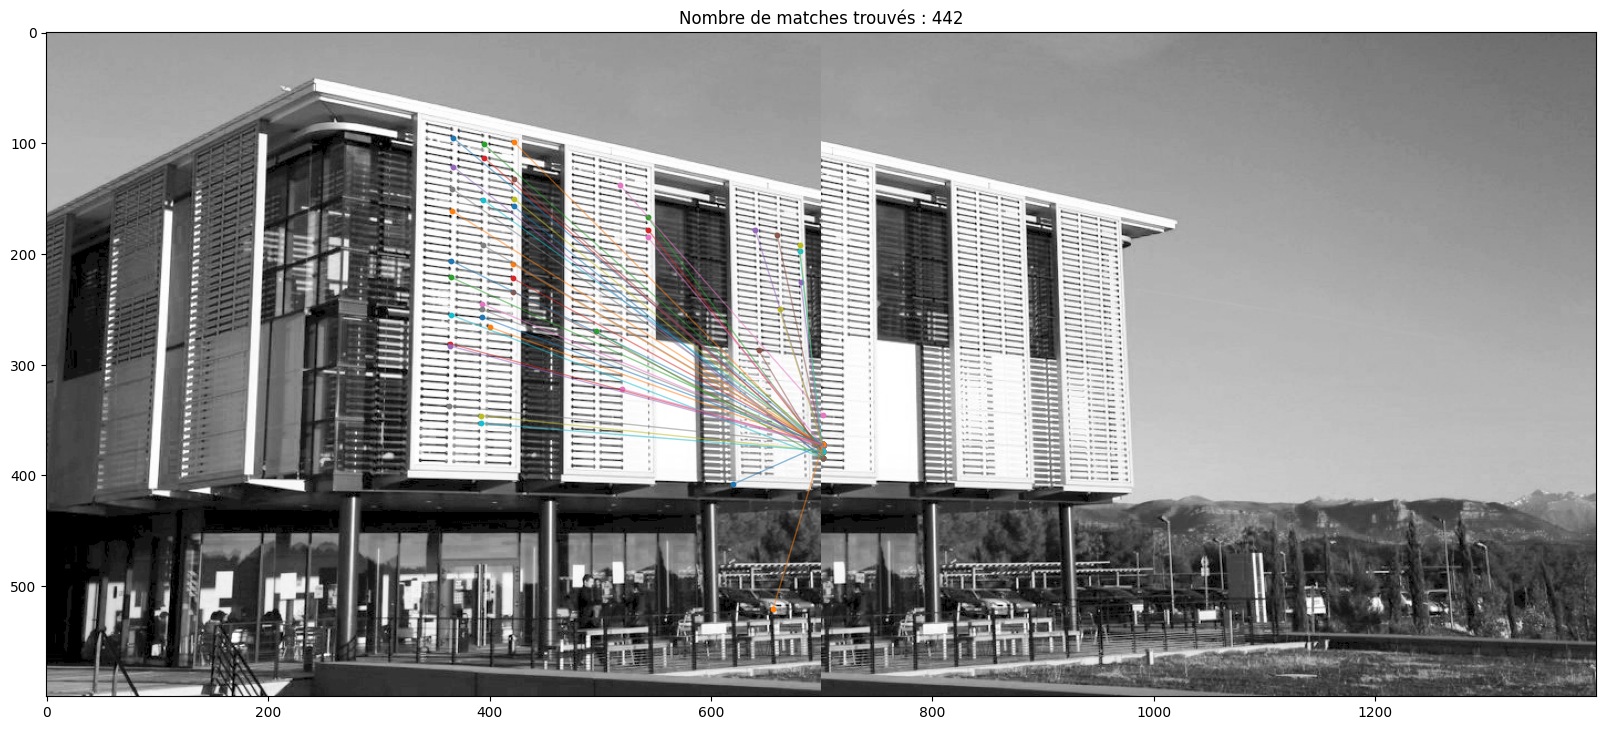

In [215]:
image_combinee = np.hstack((img1, img2))
offset = img1.shape[1] # La largeur de la première image

plt.figure(figsize=(20, 10))
plt.imshow(image_combinee, cmap='gray')

# On trace les lignes pour chaque match
for idx_A, idx_B in matching_points[best_inlier_indices]:
    # On récupère les coordonnées (y, x) depuis les listes de corners filtrées
    yA, xA = valid_idx1[idx_A]
    yB, xB = valid_idx2[idx_B]
    
    # On trace la ligne (xA, yA) -> (xB + offset, yB)
    plt.plot([xA, xB + offset], [yA, yB], alpha=0.5, linewidth=1)
    plt.scatter([xA, xB + offset], [yA, yB], s=10)

plt.title(f"Nombre de matches trouvés : {len(matching_points)}")
plt.show()

In [ ]:
plt.imshow(img1, cmap='gray')
plt.scatter(corners_img1[1], corners_img1[0], s=10, c='red', marker='.')
plt.show()